In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from datetime import datetime, timedelta

from control.modules.pvt import PvtControl, PvtParameters
from input_output.base import Stamped
from input_output.definitions.control import Valve
from input_output.definitions.simulation import (
    Boundary,
    HeatSource,
    TemperatureBoundary,
    ValvePosition,
)
from input_output.modules.pvt import PvtSensorValues, PvtSimulationInputs, PvtSimulationOutputs
from orchestration.collector import PolarsCollector

from orchestration.executor import SimulationExecutor

from simulation.fmu import Fmu
from simulation.io_mapping import IoMapping
from simulation.models.fmu_paths import pvt_path



collector = PolarsCollector()

executor = SimulationExecutor(
    IoMapping(Fmu(pvt_path), PvtSensorValues, PvtSimulationOutputs),
    PvtSimulationInputs(
    pvt_main_fwd=HeatSource(heat_flow=Stamped.stamp(100000.0)),
    pvt_main_aft=HeatSource(heat_flow=Stamped.stamp(50000.0)),
    pvt_owners=HeatSource(heat_flow=Stamped.stamp(10000.0)),
    pvt_pump_failure_switch_main_fwd=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_pump_failure_switch_main_aft=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_pump_failure_switch_owners=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_module_supply=TemperatureBoundary(temperature=Stamped.stamp(85)),
    pvt_seawater_supply=Boundary(temperature=Stamped.stamp(32), flow=Stamped.stamp(10)),
    ),
    datetime.now(),
    timedelta(seconds=1),
)
control = PvtControl(PvtParameters())


control_values = control.initial(executor.time()).values
result = await executor.tick(control_values)

#stabilize
for i in range(10):
    control_values = control.control(result.sensor_values, executor.time()).values
    result = await executor.tick(control_values)
    collector.collect(result.raw, control.mode, result.timestamp)

control.to_recovery()  # type: ignore
for i in range(10):
    control_values = control.control(result.sensor_values, executor.time()).values
    result = await executor.tick(control_values)
    collector.collect(result.raw, control.mode, result.timestamp)

print({var.name: result.read_fmu_value(var.name) for var in result.find_fmu_variables('__on__bool')})

for i in range(10):
    control_values = control.control(result.sensor_values, executor.time()).values
    result = await executor.tick(control_values)
    collector.collect(result.raw, control.mode, result.timestamp)

print({var.name: result.read_fmu_value(var.name) for var in result.find_fmu_variables('__on__bool')})



  Variable DymolaConvertInputToREAL0 = 1 at time 11
  Variable DymolaConvertInputToREAL1 = 1 at time 11
  Variable DymolaConvertInputToREAL2 = 1 at time 11
  Variable pvt_panels.pvt_pump_main_aft.pvt_pump__on__timer.entryTime = 11 at time 11
  Variable pvt_panels.pvt_pump_main_fwd.pvt_pump__on__timer.entryTime = 11 at time 11
  Variable pvt_panels.pvt_pump_owners.pvt_pump__on__timer.entryTime = 11 at time 11
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 11.1596, mxstep steps taken before reaching tout.


/Users/alje/Repos/zero/zero-thrs-control/src/orchestration/collector.py:25: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  self._data.vstack(pl.DataFrame({**values, 'time': time, 'control_mode': control_mode}, schema_overrides = self._schema, strict = False), in_place=True)


{'pvt_panels.pvt_pump_owners.pvt_pump__on__bool': 1.0, 'pvt_panels.pvt_pump_main_aft.pvt_pump__on__bool': 1.0, 'pvt_panels.pvt_pump_main_fwd__on__bool': 1.0, 'pvt_panels.pvt_pump_main_aft__on__bool': 1.0, 'pvt_panels.pvt_pump_owners__on__bool': 1.0, 'pvt_panels.pvt_pump_main_fwd.pvt_pump__on__bool': 1.0, 'pvt_pump_owners__on__bool': 1.0, 'pvt_pump_main_aft__on__bool': 1.0, 'pvt_pump_main_fwd__on__bool': 1.0}
{'pvt_panels.pvt_pump_owners.pvt_pump__on__bool': 1.0, 'pvt_panels.pvt_pump_main_aft.pvt_pump__on__bool': 1.0, 'pvt_panels.pvt_pump_main_fwd__on__bool': 1.0, 'pvt_panels.pvt_pump_main_aft__on__bool': 1.0, 'pvt_panels.pvt_pump_owners__on__bool': 1.0, 'pvt_panels.pvt_pump_main_fwd.pvt_pump__on__bool': 1.0, 'pvt_pump_owners__on__bool': 1.0, 'pvt_pump_main_aft__on__bool': 1.0, 'pvt_pump_main_fwd__on__bool': 1.0}


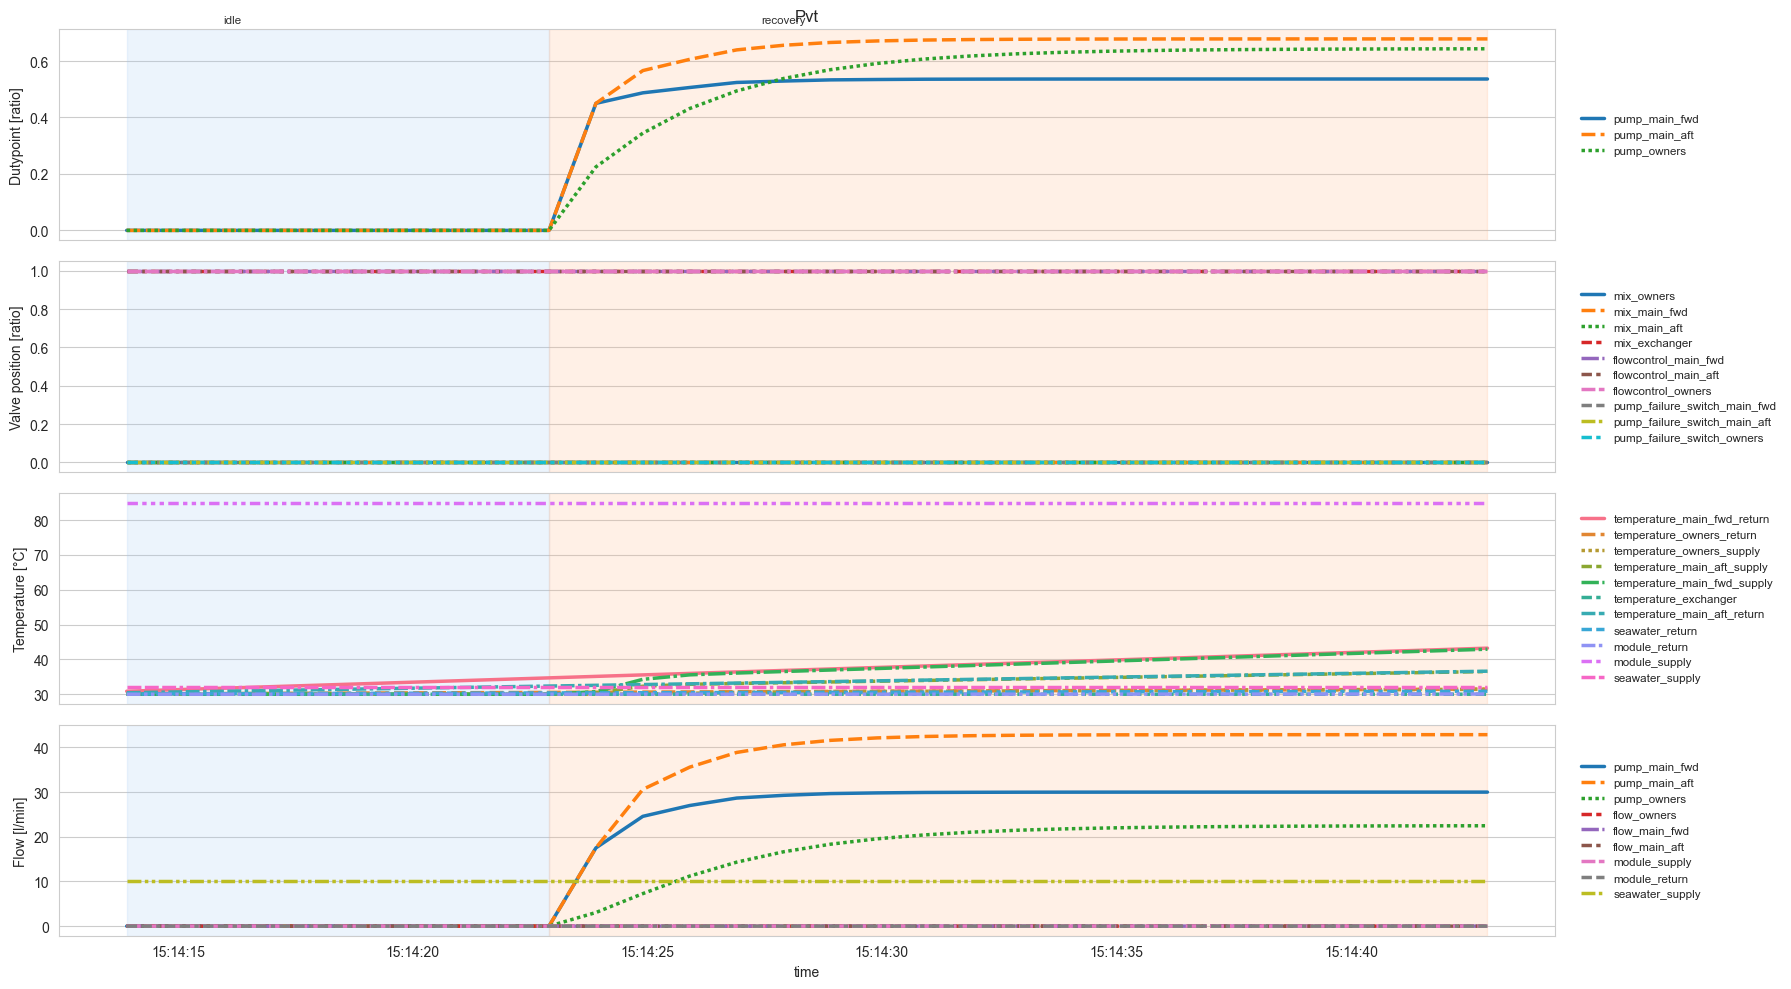

In [5]:
from analysis.analysis_utils import plot_result


plot_result(collector.result(), 'plots/pvt_test.png');


In [6]:
from datetime import datetime, timedelta

from control.modules.pvt import PvtControl, PvtParameters
from input_output.alarms import BaseAlarms
from input_output.base import Stamped
from input_output.definitions.control import Valve
from input_output.definitions.simulation import (
    Boundary,
    HeatSource,
    TemperatureBoundary,
    ValvePosition,
)

from input_output.modules.pvt import (
    PvtControlValues,
    PvtSensorValues,
    PvtSimulationInputs,
    PvtSimulationOutputs,
)
from orchestration.simulator import Simulator, SimulatorModel
from simulation.models.fmu_paths import pvt_path

start_time = datetime.fromtimestamp(0)
duration = timedelta(minutes=59)


simulation_inputs = PvtSimulationInputs(
    pvt_main_fwd=HeatSource(heat_flow=Stamped.stamp(50000.0)),
    pvt_main_aft=HeatSource(heat_flow=Stamped.stamp(3000.0)),
    pvt_owners=HeatSource(heat_flow=Stamped.stamp(1000.0)),
    pvt_pump_failure_switch_main_fwd=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_pump_failure_switch_main_aft=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_pump_failure_switch_owners=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_module_supply=TemperatureBoundary(temperature=Stamped.stamp(40)),
    pvt_seawater_supply=Boundary(temperature=Stamped.stamp(32), flow=Stamped.stamp(10)),
)

control = PvtControl(PvtParameters())

pvt_model = SimulatorModel(
    fmu_path=pvt_path,
    sensor_values_cls=PvtSensorValues,
    control_values_cls=PvtControlValues,
    simulation_outputs_cls=PvtSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control=control,
    alarms=BaseAlarms(),
    tick_duration=timedelta(seconds=1),
    start_time=start_time,
)
with pvt_model.executor() as executor:
    simulation = Simulator(pvt_model, executor)

    control.to_idle()

    result = await simulation.run(2*60)

    control.to_recovery()

    result2 = await simulation.run(5*60)

    result = result.vstack(result2)


  Variable DymolaConvertInputToREAL0 = 1 at time 120
  Variable DymolaConvertInputToREAL1 = 1 at time 120
  Variable DymolaConvertInputToREAL2 = 1 at time 120
  Variable pvt_panels.pvt_pump_main_aft.pvt_pump__on__timer.entryTime = 120 at time 120
  Variable pvt_panels.pvt_pump_main_fwd.pvt_pump__on__timer.entryTime = 120 at time 120
  Variable pvt_panels.pvt_pump_owners.pvt_pump__on__timer.entryTime = 120 at time 120
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 121.327, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 122.523, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 251.318, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 253.152, mxstep steps taken before reaching tout.


/var/folders/w7/x3ddjmps2dvfqdrygwzccnd00000gn/T/ipykernel_98428/718338151.py:69: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  result = result.vstack(result2)


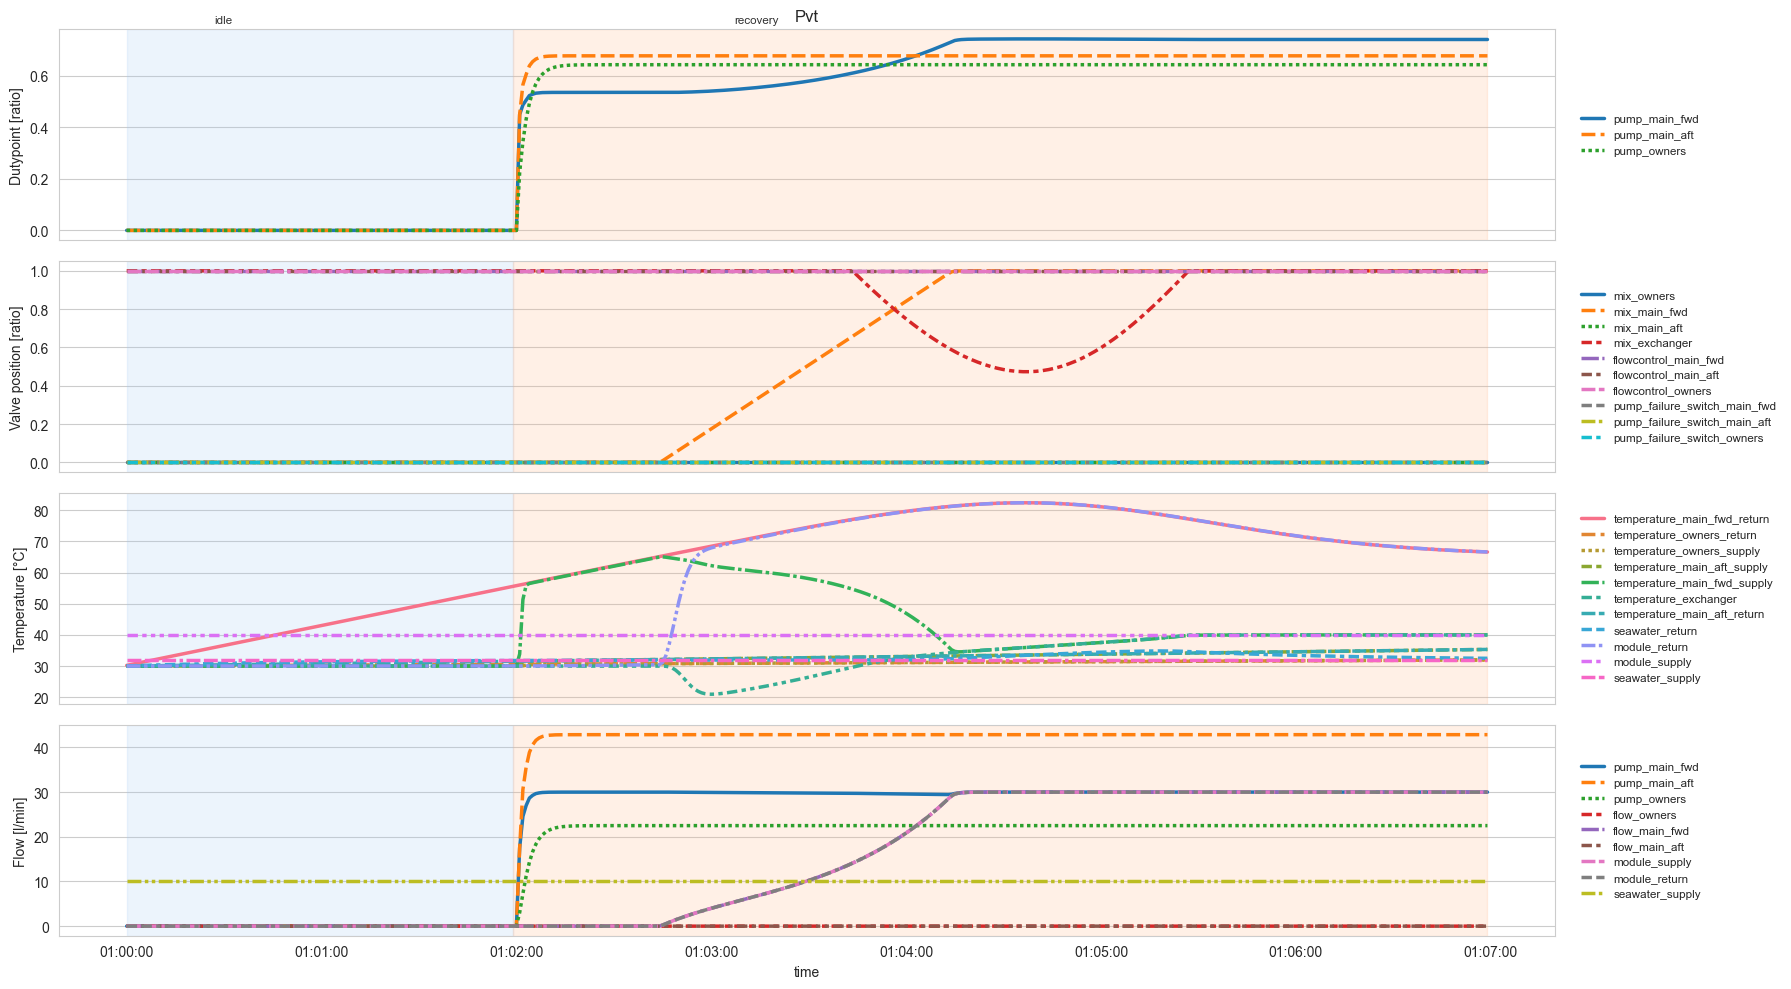

In [7]:
from analysis.analysis_utils import plot_result

plot_result(result, 'plots/pvt_test.png');

In [8]:
#Heat dump test

In [9]:
from datetime import datetime, timedelta

from control.modules.pvt import PvtControl, PvtParameters
from input_output.base import Stamped
from input_output.definitions.control import Valve
from input_output.definitions.simulation import (
    Boundary,
    HeatSource,
    TemperatureBoundary,
    ValvePosition,
)
from input_output.modules.pvt import PvtSensorValues, PvtSimulationInputs, PvtSimulationOutputs
from orchestration.collector import PolarsCollector

from orchestration.executor import SimulationExecutor

from simulation.fmu import Fmu
from simulation.io_mapping import IoMapping
from simulation.models.fmu_paths import pvt_path



collector = PolarsCollector()

executor = SimulationExecutor(
    IoMapping(Fmu(pvt_path), PvtSensorValues, PvtSimulationOutputs),
    PvtSimulationInputs(
    pvt_main_fwd=HeatSource(heat_flow=Stamped.stamp(0.0)),
    pvt_main_aft=HeatSource(heat_flow=Stamped.stamp(0.0)),
    pvt_owners=HeatSource(heat_flow=Stamped.stamp(0.0)),
    pvt_pump_failure_switch_main_fwd=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_pump_failure_switch_main_aft=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_pump_failure_switch_owners=ValvePosition(
        position_rel=Stamped.stamp(Valve.CLOSED)
    ),
    pvt_module_supply=TemperatureBoundary(temperature=Stamped.stamp(90)),
    pvt_seawater_supply=Boundary(temperature=Stamped.stamp(10), flow=Stamped.stamp(200)),
    ),
    datetime.now(),
    timedelta(seconds=1),
)
control = PvtControl(PvtParameters())



control._current_values.pvt_pump_main_fwd.dutypoint.value = 1.0
control._current_values.pvt_pump_main_aft.dutypoint.value = 1.0
control._current_values.pvt_pump_owners.dutypoint.value = 1.0
control._current_values.pvt_pump_main_fwd.on.value = True
control._current_values.pvt_pump_main_aft.on.value = True
control._current_values.pvt_pump_owners.on.value = True
control._current_values.pvt_mix_main_fwd.setpoint.value = Valve.MIXING_A_TO_AB
control._current_values.pvt_mix_main_aft.setpoint.value = Valve.MIXING_A_TO_AB
control._current_values.pvt_mix_owners.setpoint.value = Valve.MIXING_A_TO_AB
control._current_values.pvt_mix_exchanger.setpoint.value = Valve.MIXING_A_TO_AB

result = await executor.tick(
    control._current_values)

# Pre-heat PVT with hot supply water to skip time needed to warm up
while (
    result.simulation_outputs.pvt_module_return.temperature.value < control.parameters.mix_temperature_setpoint
):  # type: ignore
    control_values = control.control(result.sensor_values, executor.time()).values
    control._current_values.pvt_pump_main_fwd.dutypoint.value = 1.0
    control._current_values.pvt_pump_main_aft.dutypoint.value = 1.0
    control._current_values.pvt_pump_owners.dutypoint.value = 1.0
    control._current_values.pvt_pump_main_fwd.on.value = True
    control._current_values.pvt_pump_main_aft.on.value = True
    control._current_values.pvt_pump_owners.on.value = True
    control_values.pvt_mix_main_fwd.setpoint.value = Valve.MIXING_A_TO_AB
    control_values.pvt_mix_main_aft.setpoint.value = Valve.MIXING_A_TO_AB
    control_values.pvt_mix_owners.setpoint.value = Valve.MIXING_A_TO_AB
    control_values.pvt_mix_exchanger.setpoint.value = Valve.MIXING_A_TO_AB

    result = await executor.tick(control_values)
    collector.collect(result.raw, control.mode, result.timestamp)

print(result.timestamp)
control.to_recovery()
#pre-heat exchanger
for i in range(60):
    control_values = control.control(result.sensor_values, executor.time()).values
    control_values.pvt_mix_main_fwd.setpoint.value = Valve.MIXING_A_TO_AB
    control_values.pvt_mix_main_aft.setpoint.value = Valve.MIXING_A_TO_AB
    control_values.pvt_mix_owners.setpoint.value = Valve.MIXING_A_TO_AB
    control_values.pvt_mix_exchanger.setpoint.value = Valve.MIXING_B_TO_AB
    result = await executor.tick(control_values)
    collector.collect(result.raw, control.mode, result.timestamp)

print(result.timestamp)

for i in range(300):
    control_values = control.control(result.sensor_values, executor.time()).values
    result = await executor.tick(control_values)
    collector.collect(result.raw, control.mode, result.timestamp)

  Variable DymolaConvertInputToREAL0 = 1 at time 0
  Variable DymolaConvertInputToREAL1 = 1 at time 0
  Variable DymolaConvertInputToREAL2 = 1 at time 0
  Variable DymolaConvertInputToREAL0 = 1 at time 0
  Variable DymolaConvertInputToREAL1 = 1 at time 0
  Variable DymolaConvertInputToREAL2 = 1 at time 0
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 6.17154, mxstep steps taken before reaching tout.
2025-09-01 16:22:25.800464
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 149.575, mxstep steps taken before reaching tout.


/Users/alje/Repos/zero/zero-thrs-control/src/orchestration/collector.py:25: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  self._data.vstack(pl.DataFrame({**values, 'time': time, 'control_mode': control_mode}, schema_overrides = self._schema, strict = False), in_place=True)


[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 150.481, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 154.611, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 156.339, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 158.799, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 161.091, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 162.928, mxstep steps taken before reaching tout.
2025-09-01 16:23:25.800464
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 209.587, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 222.166, mxstep steps taken before reaching tout.
[WARNING] CVODE: CVode failed with CV_TOO_MUCH_WORK:
 At t = 229.941, mxstep steps ta

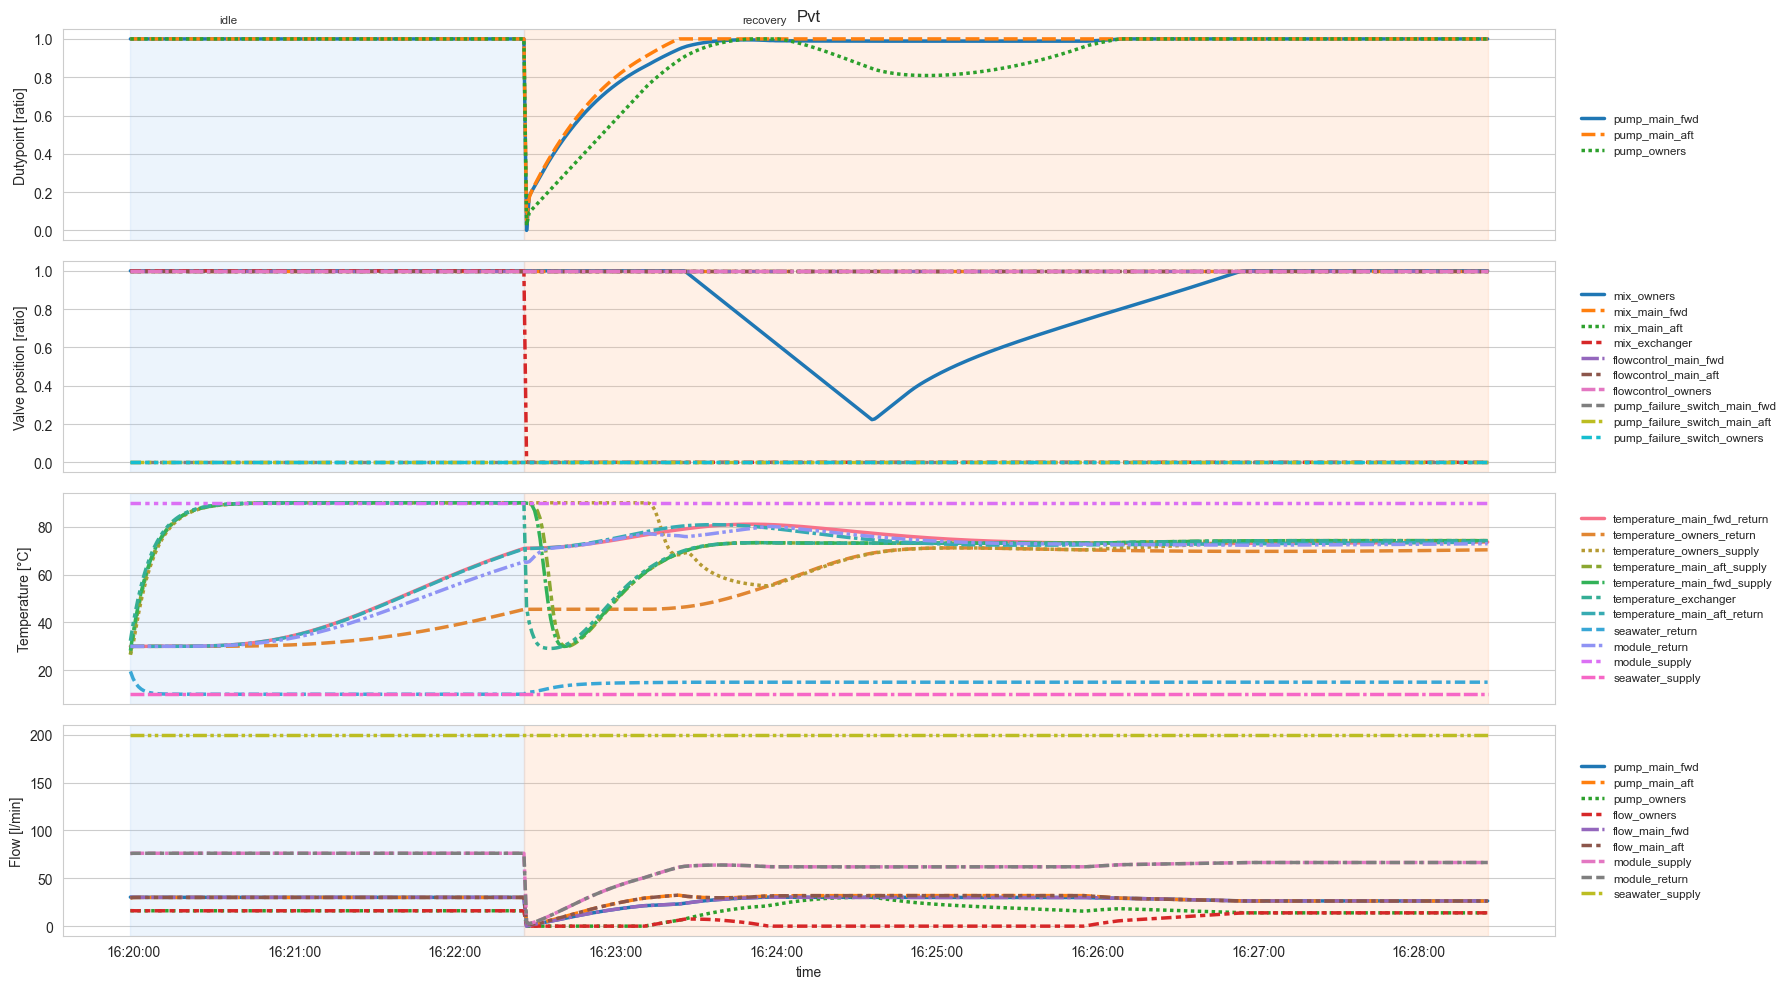

In [11]:
from analysis.analysis_utils import plot_result

plot_result(collector.result(), 'plots/pvt_test.png');

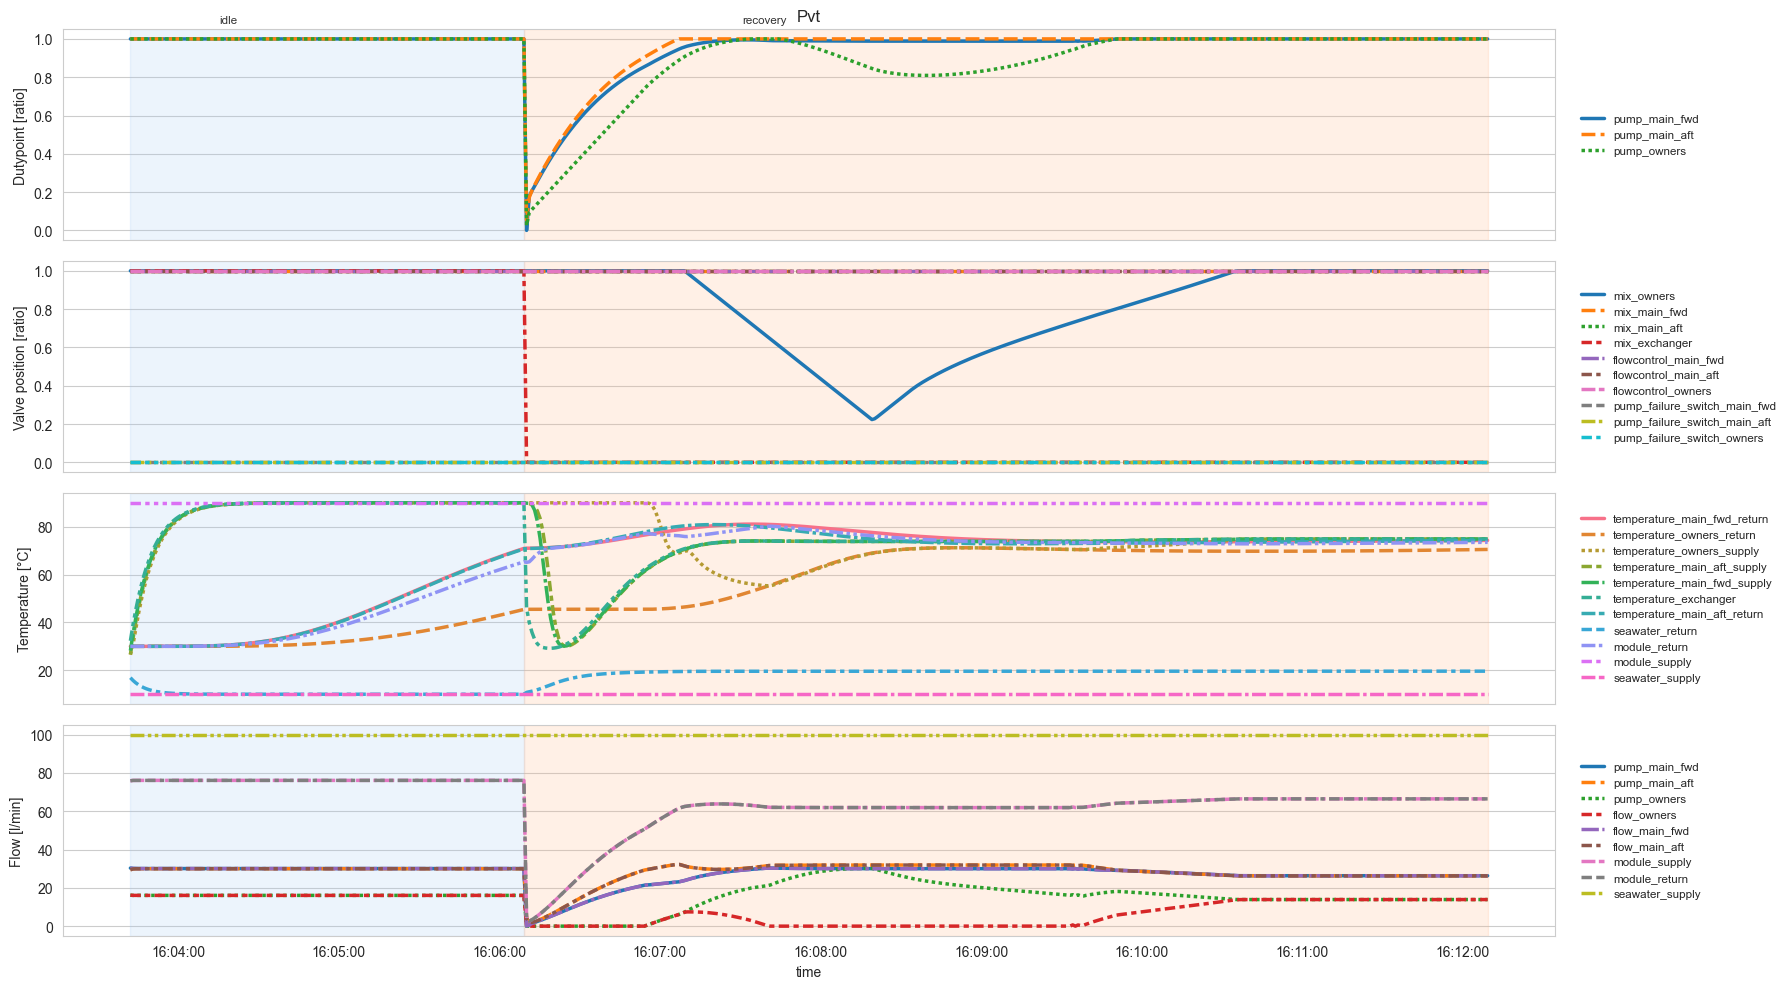

In [ ]:
from analysis.analysis_utils import plot_result

plot_result(collector.result(), 'plots/pvt_test.png');